In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
import math
from pathlib import Path
from skimage.util import img_as_float
from skimage import data, color, morphology, img_as_float
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Rescaling, GlobalAveragePooling2D, RandomFlip, RandomRotation, SeparableConv2D, Dropout
from tensorflow.keras import Input, Model
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.model_selection import train_test_split as tts
import imageio
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn import datasets, svm, pipeline
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.math import confusion_matrix
import seaborn as sns
import time

## Data Processing
### Data is ingested and made suitable for a CNN

In [7]:
trimmed_data = pd.read_csv("trimmed_dataset.csv",index_col=0)
trimmed_data.head()

,lesion_id,image_id,dx
0,HAM_0000118,ISIC_0027419,bkl
1,HAM_0000118,ISIC_0025030,bkl
2,HAM_0002730,ISIC_0026769,bkl
3,HAM_0002730,ISIC_0025661,bkl
4,HAM_0001466,ISIC_0031633,bkl


In [8]:
trimmed_data.sort_values(by="lesion_id",axis=0,inplace=True)
# trimmed_data=pd.get_dummies(trimmed_data,columns=["dx"])
trimmed_data.drop("lesion_id",axis=1,inplace=True)
# trimmed_data.set_index("image_id",inplace=True)
trimmed_data.head()

,image_id,dx
9187,ISIC_0028498,nv
9188,ISIC_0025346,nv
726,ISIC_0027859,bkl
1661,ISIC_0032622,mel
1660,ISIC_0033848,mel


In [9]:
row_keys = trimmed_data.columns.values

In [10]:
d = dict(zip(trimmed_data["image_id"],trimmed_data["dx"]))
d['ISIC_0032622']

'mel'

In [11]:
train_dir = "C:/Users/isaac/Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/original_with_segmentation/train"
test_dir = "C:/Users/isaac/Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/original_with_segmentation/test"

In [12]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                       shuffle=True,
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE)

Found 7962 files belonging to 7 classes.
Found 2053 files belonging to 7 classes.


In [13]:
class_names = train_dataset.class_names

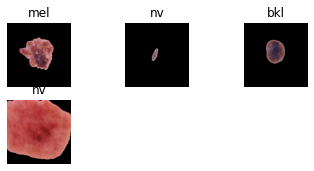

In [14]:
for images, labels in train_dataset.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
val_batches = tf.data.experimental.cardinality(train_dataset)
validation_dataset = train_dataset.take(val_batches // 10)
train_dataset = train_dataset.skip(val_batches // 10)

In [16]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 24
Number of test batches: 65


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [18]:
IMG_SHAPE = IMG_SIZE + (3,)

# ----------------------------------

## Run to here to preprocess data

# ----------------------------------

## Below is train model with base_model NOT trainable

In [46]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
preprocess_input = tf.keras.applications.resnet50.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [51]:
base_model = ResNet50(input_shape=IMG_SHAPE,
                    include_top=False,
                    weights='imagenet')

In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

NameError: name 'base_model' is not defined

In [53]:
base_model.trainable = False

In [54]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [55]:
prediction_layer = tf.keras.layers.Dense(7,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 7)


In [56]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.25)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [57]:
base_learning_rate = 0.0001
EPOCHS=400
callbacks = EarlyStopping(monitor="loss",patience=30,restore_best_weights=True)
lrPlateau = ReduceLROnPlateau(monitor="val_loss",patience=15)
NAME="resnet50-global-epochs-{}-blr-{}-time-{}".format(EPOCHS,base_learning_rate,time.time())
tensorboard = TensorBoard(log_dir="logs_imagenet/-{}".format(NAME))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [58]:
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0   

In [59]:
history = model.fit(train_dataset,
                    verbose=1,
                    epochs=EPOCHS,
                    validation_data=test_dataset,
                   callbacks=[callbacks,tensorboard,lrPlateau])

Epoch 1/400
225/225 [==============================] - 21s 82ms/step - loss: 1.3550 - accuracy: 0.5870 - val_loss: 1.0289 - val_accuracy: 0.6629 - lr: 1.0000e-04
Epoch 2/400
225/225 [==============================] - 18s 76ms/step - loss: 1.0243 - accuracy: 0.6710 - val_loss: 0.8847 - val_accuracy: 0.6883 - lr: 1.0000e-04
Epoch 3/400
225/225 [==============================] - 18s 77ms/step - loss: 0.9183 - accuracy: 0.6888 - val_loss: 0.8288 - val_accuracy: 0.6980 - lr: 1.0000e-04
Epoch 4/400
225/225 [==============================] - 18s 77ms/step - loss: 0.8539 - accuracy: 0.7056 - val_loss: 0.7759 - val_accuracy: 0.7214 - lr: 1.0000e-04
Epoch 5/400
225/225 [==============================] - 18s 76ms/step - loss: 0.8060 - accuracy: 0.7116 - val_loss: 0.7508 - val_accuracy: 0.7321 - lr: 1.0000e-04
Epoch 6/400
225/225 [==============================] - 18s 76ms/step - loss: 0.7910 - accuracy: 0.7180 - val_loss: 0.7425 - val_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 7/400
225/225 [=======

In [136]:
loss0, accuracy0 = model.evaluate(validation_dataset)

24/24 [==============================] - 2s 57ms/step - loss: 0.5376 - accuracy: 0.8086


In [137]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.4f}".format(accuracy0))

initial loss: 0.54
initial accuracy: 0.8086


In [62]:
y_actual = np.array([])
preds = model.predict(validation_dataset)
for x in validation_dataset:
    # print(np.array(x[1]))
    # break
    y_actual = np.concatenate((y_actual,np.array(x[1])))

In [63]:
preds = np.array([np.argmax(x) for x in preds])
preds

array([2, 5, 6, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 2, 5, 2, 5, 2,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 2, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 1, 4,
       4, 5, 2, 1, 6, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 6, 4, 2, 5, 5,
       5, 5, 2, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 5, 1, 5, 2, 5,
       5, 0, 5, 1, 5, 5, 5, 5, 5, 6, 5, 2, 6, 5, 5, 5, 5, 5, 5, 1, 5, 5,
       5, 5, 5, 1, 2, 5, 5, 5, 5, 2, 5, 5, 5, 5, 6, 5, 2, 5, 1, 5, 5, 5,
       5, 5, 5, 2, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 1, 5, 2, 5, 2, 5,
       5, 1, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 1, 5, 5, 5, 5, 2, 5, 6, 5,
       5, 5, 5, 1, 5, 5, 1, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 4, 2, 5, 5,
       5, 5, 5, 5, 5, 5, 4, 1, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 1, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 2,
       2, 1, 4, 5, 5, 2, 2, 2, 1, 5, 5, 5, 5, 5, 2,

In [64]:
conf = tf.math.confusion_matrix(y_actual,preds)

Text(0.5, 15.0, 'Predictions')

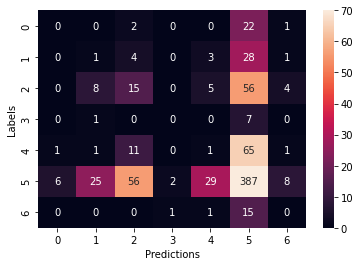

In [65]:
ax = sns.heatmap(conf,annot=True,fmt=".3g",vmin=0,vmax=70)
ax.set_ylabel("Labels")
ax.set_xlabel("Predictions")

In [66]:
pred_label, pred_count = np.unique(preds,return_counts=True)
pred_count

array([  7,  36,  88,   3,  39, 580,  15], dtype=int64)

In [67]:
actual_label, actual_count = np.unique(y_actual,return_counts=True)

In [68]:
p_labels = [str(x)+" Predicted" for x in pred_label]
a_labels = [str(x)+" Actual" for x in actual_label]

In [69]:
comb_labels = []

for i in range(7):
    comb_labels += [p_labels[i]]
    comb_labels += [a_labels[i]]

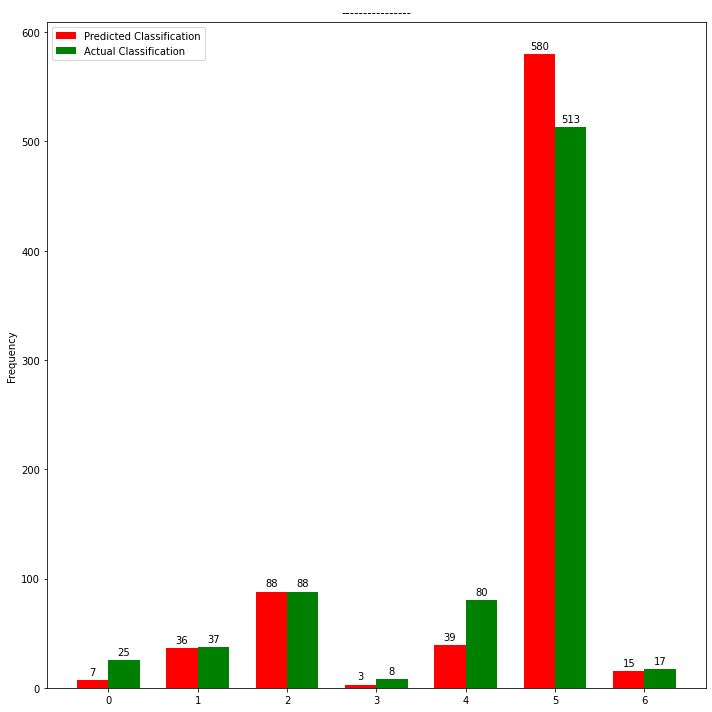

In [70]:
f = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)

width = 0.35
x = np.arange(len(pred_label))

pred_bars = ax.bar(x - width/2, pred_count,width=width, color="red",label="Predicted Classification")
actual_bars = ax.bar(x + width/2, actual_count,width=width, color="green",label="Actual Classification")
ax.set_ylabel("Frequency")
ax.set_title("----------------")
ax.set_xticks(x,pred_label)
ax.legend()
ax.bar_label(pred_bars, padding=3)
ax.bar_label(actual_bars, padding=3)

f.tight_layout()
plt.show()

## Run to here to preprocess data

# ----------------------------------

## Below is train model with base_model.trainable=TRUE.
## Here we load from saved version of model trained above

In [122]:
# model.save_weights("imagenet_models/ResNet50/epochs-{}-blr-{}-trainable-{}/weights".format(EPOCHS,base_learning_rate,"false"))
# model.save("imagenet_models/ResNet50/epochs-{}-blr-{}-trainable-{}/full-model".format(EPOCHS,base_learning_rate,"false"))

In [24]:
trainable_model = tf.keras.models.load_model("C:/Users/isaac/Documents/Programming/Skin Cancer Analysis and Predictions/Goal 1/imagenet_models/ResNet50/epochs-400-blr-0.0001-trainable-false/full-model")
trainable_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0   

In [25]:
trainable_model.load_weights("C:/Users/isaac/Documents/Programming/Skin Cancer Analysis and Predictions/Goal 1/imagenet_models/ResNet50/epochs-400-blr-0.0001-trainable-false/weights")

In [26]:
trainable_model.evaluate(validation_dataset)

24/24 [==============================] - 2s 57ms/step - loss: 0.5043 - accuracy: 0.8047


[0.5042508244514465, 0.8046875]

In [27]:
trainable_model.trainable = True

In [28]:
trainable_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0   

In [29]:
base_learning_rate = 0.000001
EPOCHS=400
callbacks = EarlyStopping(monitor="val_loss",patience=20,restore_best_weights=True)
lrPlateau = ReduceLROnPlateau(monitor="val_loss",patience=10)
NAME="resnet50-global-epochs-{}-blr-{}-trainable-{}-time-{}".format(EPOCHS,base_learning_rate,"TRUE",str(time.time())[:8])
tensorboard = TensorBoard(log_dir="logs_imagenet/{}".format(NAME))
trainable_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [30]:
history = trainable_model.fit(train_dataset,
                    verbose=1,
                    epochs=EPOCHS,
                    validation_data=test_dataset,
                   callbacks=[callbacks,tensorboard,lrPlateau])

Epoch 1/400
225/225 [==============================] - 45s 186ms/step - loss: 0.5136 - accuracy: 0.8090 - val_loss: 0.5970 - val_accuracy: 0.7891 - lr: 1.0000e-06
Epoch 2/400
225/225 [==============================] - 41s 182ms/step - loss: 0.4965 - accuracy: 0.8139 - val_loss: 0.5827 - val_accuracy: 0.7954 - lr: 1.0000e-06
Epoch 3/400
225/225 [==============================] - 41s 181ms/step - loss: 0.4906 - accuracy: 0.8205 - val_loss: 0.5735 - val_accuracy: 0.8003 - lr: 1.0000e-06
Epoch 4/400
225/225 [==============================] - 41s 180ms/step - loss: 0.4775 - accuracy: 0.8212 - val_loss: 0.5669 - val_accuracy: 0.8037 - lr: 1.0000e-06
Epoch 5/400
225/225 [==============================] - 41s 179ms/step - loss: 0.4609 - accuracy: 0.8315 - val_loss: 0.5702 - val_accuracy: 0.8003 - lr: 1.0000e-06
Epoch 6/400
225/225 [==============================] - 41s 180ms/step - loss: 0.4604 - accuracy: 0.8269 - val_loss: 0.5668 - val_accuracy: 0.8022 - lr: 1.0000e-06
Epoch 7/400
225/225 [=

# ---------------------------
## Loading Trained Model

In [94]:
for x in validation_dataset:
    print(x)

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],




In [20]:
trained_model = tf.keras.models.load_model("C:/Users/isaac/Documents/Programming/Skin Cancer Analysis and Predictions/Goal 1/imagenet_models/ResNet50/epochs-400-blr-1e-06-trainable-true/full-model")


In [21]:
trained_model.load_weights("C:/Users/isaac/Documents/Programming/Skin Cancer Analysis and Predictions/Goal 1/imagenet_models/ResNet50/epochs-400-blr-1e-06-trainable-true/weights")

In [112]:
topk = tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=2, name="top_k_categorical_accuracy", dtype=None
)
trained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[topk])

In [113]:
trained_model.evaluate(validation_dataset)

24/24 [==============================] - 2s 60ms/step - loss: 0.3022 - top_k_categorical_accuracy: 0.9688


[0.3022347092628479, 0.96875]

In [116]:
topKaccuracy = {i:[] for i in range(6)}
topKloss = {i:[] for i in range(6)}

### Evaluate Accuracy and Loss with SparseTopKAccuracy

In [121]:
for j in range(1,6):
    topk = tf.keras.metrics.SparseTopKCategoricalAccuracy(
        k=j+1, name="top_k_categorical_accuracy", dtype=None
    )
    trained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[topk])
    print(a,j)
    loss, acc = trained_model.evaluate(validation_dataset)
    topKaccuracy[j].append(acc)
    topKloss[j].append(loss)
    for a in range(29):
        if a%10==0:
            print(a,j)
            print(topKaccuracy,topKloss)
        loss, acc = trained_model.evaluate(validation_dataset)
        topKaccuracy[j].append( ( ( ( topKaccuracy[j][-1] * len(topKaccuracy[j]) ) + acc) / (len(topKaccuracy[j])+1) ) )
        topKloss[j].append( ( ( ( topKloss[j][-1] * len(topKloss[j]) ) + loss) / ( len(topKloss[j]) + 1 ) ) )
        

51 1
24/24 [==============================] - 3s 69ms/step - loss: 0.3215 - top_k_categorical_accuracy: 0.9648
0 1
{0: [0.8854166865348816, 0.8932291865348816, 0.8884548743565878, 0.8893229216337204, 0.8890625, 0.8875868022441864, 0.8857886876378741, 0.8849283829331398, 0.8861400418811374, 0.8854166626930237, 0.8854166648604653, 0.8846571147441864, 0.884615380030412, 0.8850446385996682, 0.8853298584620158, 0.8850911445915699, 0.8845741398194257, 0.8849826355775198, 0.8850054803647494, 0.8849609345197678, 0.8850446400188264, 0.8852391080422835, 0.8853600517563198, 0.8849826355775198, 0.8852604126930237, 0.884615380030412, 0.8847897339750219, 0.8848586274044854, 0.8846084742710508, 0.8845920105775197, 0.8847866231395353, 0.8848063126206398, 0.8846275228442568, 0.8847273255095762, 0.8847098180225917, 0.8847294532590442, 0.8846424528070398, 0.884731357034884, 0.8845486090733454, 0.8845052063465119, 0.8845591952161092, 0.884486605723699, 0.8845990785332614, 0.8846176605332982, 0.88454861111

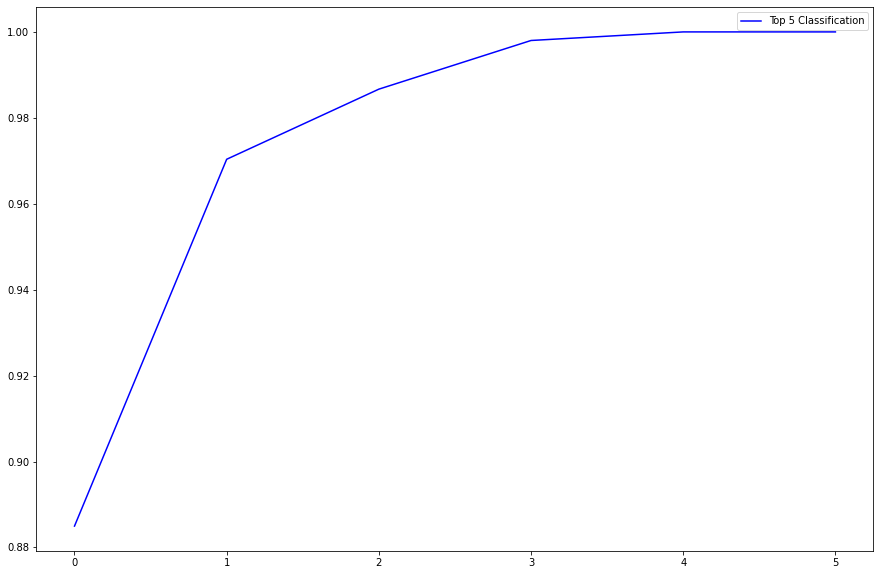

In [137]:
f2 = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
# colors = ["red","orange","yellow","green","blue","indigo"]
ax.plot([i for i in range(6)], [val[-1] for val in topKaccuracy.values()],c="blue",label="Top {} Classification".format(key))
plt.legend()
plt.show()

In [22]:
trained_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0   

### 10 repeats to create heatmap with Predictions vs Actual Classification Confusion Matrix

24/24 [==============================] - 2s 70ms/step - loss: 0.3229 - accuracy: 0.8841
initial loss: 0.32
initial accuracy: 0.8841
768
768
(array([0., 1., 2., 3., 4., 5., 6.]), array([ 13,  34,  89,   5,  62, 554,  11], dtype=int64))


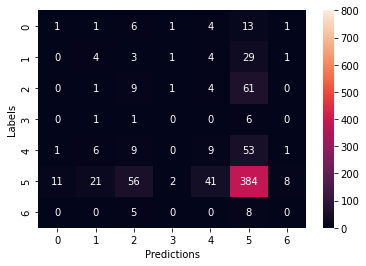

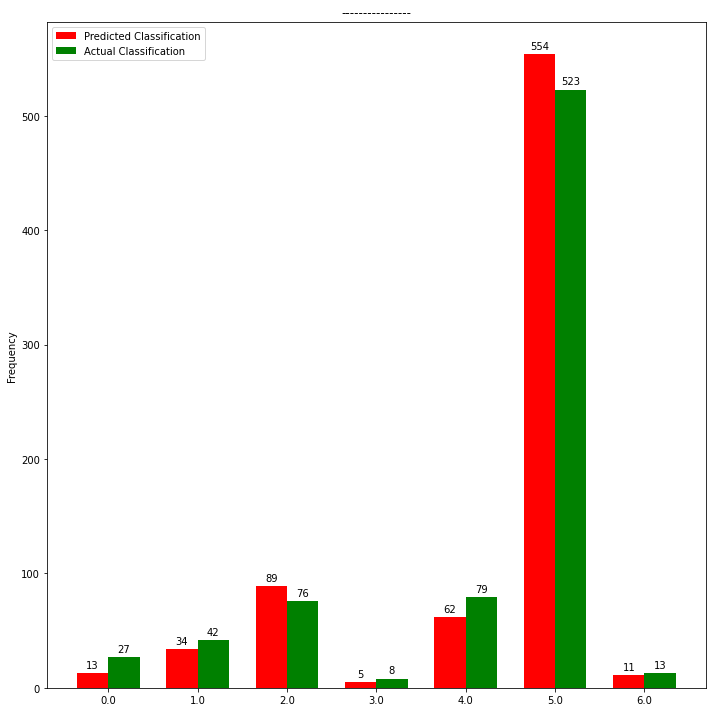

In [88]:
y_actual = np.array([])
y_preds = np.array([])
original_preds = np.array([])
loss0, accuracy0 = trained_model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.4f}".format(accuracy0))
for i in range(1):
    preds = trainable_model.predict(validation_dataset)
    
    if len(original_preds)==0:
        original_preds = np.array(preds)
    else:
        original_preds = np.concatenate((original_preds,np.array(preds)))
    # print(preds,original_preds)
    # break
    
    for x in validation_dataset:
        # print(np.array(x[1]))
        # break
        y_actual = np.concatenate((y_actual,np.array(x[1])))
    
    y_preds = np.concatenate((y_preds,[np.argmax(x) for x in preds]))
    print(len(original_preds))
    print(len(y_preds))
    print(np.unique(y_preds,return_counts=True))

conf = tf.math.confusion_matrix(y_actual,y_preds)

ax = sns.heatmap(conf,annot=True,fmt=".3g",vmin=0,vmax=800)
ax.set_ylabel("Labels")
ax.set_xlabel("Predictions")

pred_label, pred_count = np.unique(y_preds,return_counts=True)
pred_count

actual_label, actual_count = np.unique(y_actual,return_counts=True)

p_labels = [str(x)+" Predicted" for x in pred_label]
a_labels = [str(x)+" Actual" for x in actual_label]

comb_labels = []

for i in range(7):
    comb_labels += [p_labels[i]]
    comb_labels += [a_labels[i]]

f = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)

width = 0.35
x = np.arange(len(pred_label))

pred_bars = ax.bar(x - width/2, pred_count,width=width, color="red",label="Predicted Classification")
actual_bars = ax.bar(x + width/2, actual_count,width=width, color="green",label="Actual Classification")
ax.set_ylabel("Frequency")
ax.set_title("----------------")
ax.set_xticks(x,pred_label)
ax.legend()
ax.bar_label(pred_bars, padding=3)
ax.bar_label(actual_bars, padding=3)

f.tight_layout()
plt.show()

In [30]:
for _ in range(5): 
    loss0, accuracy0 = trained_model.evaluate(validation_dataset)
    print("initial loss: {:.2f}".format(loss0))
    print("initial accuracy: {:.4f}".format(accuracy0))

24/24 [==============================] - 2s 60ms/step - loss: 0.2840 - accuracy: 0.8893
initial loss: 0.28
initial accuracy: 0.8893
24/24 [==============================] - 2s 61ms/step - loss: 0.3170 - accuracy: 0.8789
initial loss: 0.32
initial accuracy: 0.8789
24/24 [==============================] - 2s 61ms/step - loss: 0.2918 - accuracy: 0.8919
initial loss: 0.29
initial accuracy: 0.8919
24/24 [==============================] - 2s 61ms/step - loss: 0.2970 - accuracy: 0.8893
initial loss: 0.30
initial accuracy: 0.8893
24/24 [==============================] - 2s 61ms/step - loss: 0.3037 - accuracy: 0.8828
initial loss: 0.30
initial accuracy: 0.8828
